## Predicting Volatility

In this project, we will attempt to build a machine learning model which predicts future realized volatility using historical volatility in relation to the mean volatility. The goal being to be able to come up with a better theoretical option value than the market and then delta hedge that edge to expiration. Aka. playing the market maker. 

* Why 45 days? 

In my personal trading I put on trades in the expiration cycle closest to 45 days away. 

In [53]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Getting and transforming the data

In [54]:
#Get stock data
ticker = 'SPY'
data = web.DataReader(ticker, 'yahoo', start='1/1/1994')
data['pct change'] = data['Close'].pct_change()
data = data[['Close', 'pct change']]
data['pct change'].iloc[0] = 0
data

,Close,pct change
Date,,
1994-01-03,46.468750,0.000000
1994-01-04,46.656250,0.004035
1994-01-05,46.750000,0.002009
1994-01-06,46.750000,0.000000
1994-01-07,47.031250,0.006016
...,...,...
2022-09-15,390.119995,-0.011353
2022-09-16,385.559998,-0.011689
2022-09-19,388.549988,0.007755


In [55]:
# Get annualized volatility data
rolling_periods = [252, 180, 90, 45, 30, 20, 10]

for period in rolling_periods:
    data[str(period)+'day_vol'] = data['pct change'].rolling(period).std() * np.sqrt(252)
data

,Close,pct change,252day_vol,180day_vol,90day_vol,45day_vol,30day_vol,20day_vol,10day_vol
Date,,,,,,,,,
1994-01-03,46.468750,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-04,46.656250,0.004035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-05,46.750000,0.002009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-06,46.750000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,47.031250,0.006016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-09-15,390.119995,-0.011353,0.217176,0.238977,0.250523,0.224171,0.224632,0.250202,0.283910
2022-09-16,385.559998,-0.011689,0.217463,0.239295,0.245533,0.225987,0.226364,0.249955,0.287387
2022-09-19,388.549988,0.007755,0.217261,0.239514,0.245862,0.222213,0.228227,0.251864,0.287947


In [56]:
#Get 45 day future realized volatility data (annualized)
data = data.iloc[::-1]
data['45day future vol'] = data['pct change'].rolling(45).std() * np.sqrt(252)
data = data.iloc[::-1]
data = data.iloc[max(rolling_periods):len(data)-44] # Get rid of NaN values
data

C:\Users\Wyatt\AppData\Local\Temp\ipykernel_23624\3231313633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['45day future vol'] = data['pct change'].rolling(45).std() * np.sqrt(252)


,Close,pct change,252day_vol,180day_vol,90day_vol,45day_vol,30day_vol,20day_vol,10day_vol,45day future vol
Date,,,,,,,,,,
1995-01-03,45.781250,0.004801,0.106636,0.105059,0.114415,0.120877,0.112173,0.090410,0.099455,0.070337
1995-01-04,46.000000,0.004778,0.106667,0.104884,0.114657,0.109935,0.113180,0.091805,0.102124,0.069912
1995-01-05,46.000000,0.000000,0.106647,0.104875,0.112000,0.109732,0.109320,0.091813,0.100328,0.069508
1995-01-06,46.046875,0.001019,0.106653,0.104868,0.112024,0.106801,0.087716,0.087317,0.084155,0.076512
1995-01-09,46.093750,0.001018,0.106485,0.103696,0.111935,0.106089,0.086548,0.078066,0.082801,0.076730
...,...,...,...,...,...,...,...,...,...,...
2022-07-14,377.910004,-0.002428,0.199743,0.224419,0.264480,0.265625,0.258253,0.234096,0.135571,0.224171
2022-07-15,385.130005,0.019105,0.200679,0.225659,0.262336,0.269773,0.265362,0.238429,0.160008,0.225987
2022-07-18,381.950012,-0.008257,0.200695,0.225790,0.262388,0.267903,0.258329,0.205509,0.160053,0.222213


<AxesSubplot:xlabel='Date'>

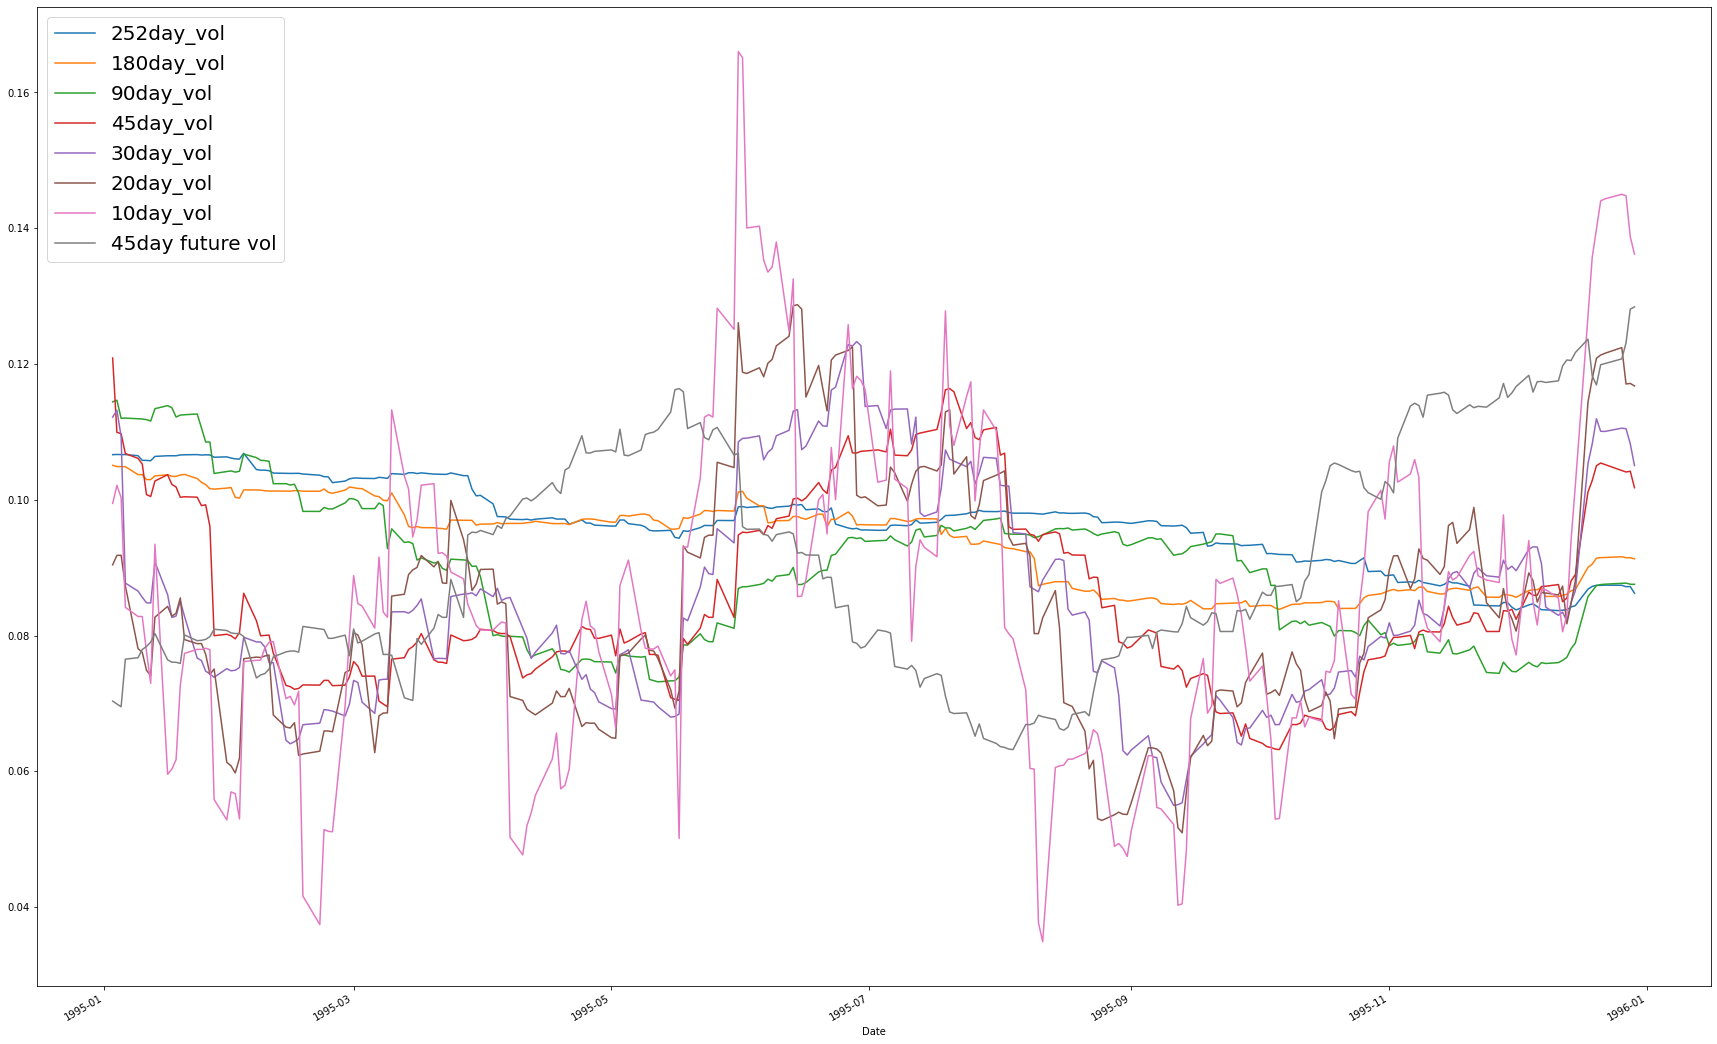

In [57]:
# Let's visualize a portion of the data
plt.rc('legend', fontsize=20)
(data.drop('Close', axis=1)).drop('pct change', axis=1).iloc[:252].plot(figsize=(30, 20))

Well I don't see anything here. Hopefully the model will.

## Model Time


In [58]:
# Get rid of Close and pct change
data = data.drop('Close', axis=1)
data = data.drop('pct change', axis=1)

In [59]:
# Break into train and test -- 8/10 to train
train = np.floor(len(data)*(8/10))
train = int(train)

X_train, y_train = data.drop('45day future vol', axis=1)[:train], data['45day future vol'][:train]
X_test, y_test = data.drop('45day future vol', axis=1)[train:], data['45day future vol'][train:]

# Import model and fit
from sklearn.ensemble import RandomForestRegressor

vol_model = RandomForestRegressor(random_state=42)
vol_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [60]:
vol_model.score(X_test, y_test)

-0.10970196989752723

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_preds = vol_model.predict(X_test)
mae = mean_absolute_error(y_test, y_preds)
mse = mean_squared_error(y_test, y_preds)

mae, mse

(0.07700681321413096, 0.013926499400873883)

Well, that sucks... let's see if it does any better cross-validated.

In [62]:
intervals = list(np.linspace(0, len(data), num=5))
intervals = [int(np.round(interval)) for interval in intervals]

r2 = []
mse = []
mae = []
for index, interval in enumerate(intervals):
    if index == 4: break
    datas = data[intervals[index]:intervals[index+1]]
    
    # Break into train and test -- 8/10 to train
    train = np.floor(len(datas)*(8/10))
    train = int(train)

    X_train, y_train = datas.drop('45day future vol', axis=1)[:train], datas['45day future vol'][:train]
    X_test, y_test = datas.drop('45day future vol', axis=1)[train:], datas['45day future vol'][train:]

    vol_model = RandomForestRegressor(random_state=42)
    vol_model.fit(X_train, y_train)
    
    y_preds = vol_model.predict(X_test)
    
    r2.append(r2_score(y_test, y_preds))
    mae.append(mean_absolute_error(y_test, y_preds))
    mse.append(mean_squared_error(y_test, y_preds))

In [63]:
np.mean(r2), np.mean(mae), np.mean(mse)

(-0.7764241992008061, 0.07546290856273825, 0.013630209563071975)

Okay... well total failure then. Let's try to include and enumerate time data and see if that helps at all.

In [64]:
data

,252day_vol,180day_vol,90day_vol,45day_vol,30day_vol,20day_vol,10day_vol,45day future vol
Date,,,,,,,,
1995-01-03,0.106636,0.105059,0.114415,0.120877,0.112173,0.090410,0.099455,0.070337
1995-01-04,0.106667,0.104884,0.114657,0.109935,0.113180,0.091805,0.102124,0.069912
1995-01-05,0.106647,0.104875,0.112000,0.109732,0.109320,0.091813,0.100328,0.069508
1995-01-06,0.106653,0.104868,0.112024,0.106801,0.087716,0.087317,0.084155,0.076512
1995-01-09,0.106485,0.103696,0.111935,0.106089,0.086548,0.078066,0.082801,0.076730
...,...,...,...,...,...,...,...,...
2022-07-14,0.199743,0.224419,0.264480,0.265625,0.258253,0.234096,0.135571,0.224171
2022-07-15,0.200679,0.225659,0.262336,0.269773,0.265362,0.238429,0.160008,0.225987
2022-07-18,0.200695,0.225790,0.262388,0.267903,0.258329,0.205509,0.160053,0.222213


In [65]:
data1 = data.reset_index()
data1['year'] = data1['Date'].dt.year
data1['month'] = data1['Date'].dt.month
data1['day'] = data1['Date'].dt.day
data1['quarter'] = data1['Date'].dt.quarter
data1

,Date,252day_vol,180day_vol,90day_vol,45day_vol,30day_vol,20day_vol,10day_vol,45day future vol,year,month,day,quarter
0,1995-01-03,0.106636,0.105059,0.114415,0.120877,0.112173,0.090410,0.099455,0.070337,1995,1,3,1
1,1995-01-04,0.106667,0.104884,0.114657,0.109935,0.113180,0.091805,0.102124,0.069912,1995,1,4,1
2,1995-01-05,0.106647,0.104875,0.112000,0.109732,0.109320,0.091813,0.100328,0.069508,1995,1,5,1
3,1995-01-06,0.106653,0.104868,0.112024,0.106801,0.087716,0.087317,0.084155,0.076512,1995,1,6,1
4,1995-01-09,0.106485,0.103696,0.111935,0.106089,0.086548,0.078066,0.082801,0.076730,1995,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6931,2022-07-14,0.199743,0.224419,0.264480,0.265625,0.258253,0.234096,0.135571,0.224171,2022,7,14,3
6932,2022-07-15,0.200679,0.225659,0.262336,0.269773,0.265362,0.238429,0.160008,0.225987,2022,7,15,3
6933,2022-07-18,0.200695,0.225790,0.262388,0.267903,0.258329,0.205509,0.160053,0.222213,2022,7,18,3
6934,2022-07-19,0.202038,0.227854,0.262450,0.275682,0.268929,0.222813,0.209437,0.223052,2022,7,19,3


In [66]:
data1.drop('Date', axis=1, inplace=True)

Okay, let's try this again.

In [67]:
train = np.floor(len(data)*(8/10))
train = int(train)

X_train, y_train = data.drop('45day future vol', axis=1)[:train], data['45day future vol'][:train]
X_test, y_test = data.drop('45day future vol', axis=1)[train:], data['45day future vol'][train:]

# Import model and fit
from sklearn.ensemble import RandomForestRegressor

vol_model1 = RandomForestRegressor(random_state=42)
vol_model1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [68]:
vol_model1.score(X_test, y_test)

-0.10970196989752723

That's what you call ZERO improvement. Looks like I will not be competing with the market makers today. 